In [2]:
import datetime as dt
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [5]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [6]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/', 
                    Selection='SiPM_31V_SourceFar_*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for File in D0.Files:
    D0.ImportDataFromHDF5(File, D0.Ch)

In [7]:
print('nr of samples: ',len(D0.Ch[1].Time))
print('total time in us: ', D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])
print('time between samples in us: ', (D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time))
print('sampling rate in MHz: ',1/((D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time)))

nr of samples:  117928
total time in us:  100002.09599999999
time between samples in us:  0.847992809171698
sampling rate in MHz:  1.1792552828092724


In [8]:
start = D0.Ch[1].Time[0]
length = D0.Ch[1].Time[-1] - D0.Ch[1].Time[0]
window = 1000
count = int(length/window)
print(start, length,window, count)

-50000.191999999995 100002.09599999999 1000 100


In [9]:
for i,Amp in enumerate(D0.Ch[1].Amp):
    print(i)
    NewAmp = Amp-np.mean(Amp)
    for j in range(count):
        offset = window*j
        cut = np.where((D0.Ch[1].Time > start+offset) & (D0.Ch[1].Time < start+offset+window))[0]
        y = D0.get_filtered_waveform(D0.Ch[1].Time, NewAmp, lowfreq=10, highfreq=100000, type='band', order=3)[cut]
        D0.fit_peaks(D0.Ch[1].Time[cut], y)

0


../../../purity-monitor/SiPM.py:68: RuntimeWarning: overflow encountered in exp
  return base + V0/2 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))
../../../purity-monitor/SiPM.py:68: RuntimeWarning: overflow encountered in multiply
  return base + V0/2 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))
../../../purity-monitor/SiPM.py:68: RuntimeWarning: invalid value encountered in multiply
  return base + V0/2 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


/gpfs/loomis/project/david_moore/aj487/conda_envs/py37s/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344

In [10]:
print(np.shape(D0.fit_parameters))
print(np.shape(D0.peak_pos))
print(np.sum([len(x) for x in D0.peak_pos]))

(56585, 5)
(70300,)
56585


In [73]:
D0.fit_parameters = np.array(D0.fit_parameters)
print(len(D0.Ch[1].Amp))
gain = 26.314841724331316
print(sorted(D0.Files))
# print(D0.Ch[1].TimeStamp)
print(np.min(D0.Ch[1].TimeStamp))
print(np.max(D0.Ch[1].TimeStamp))
total_time = np.max(D0.Ch[1].TimeStamp) - np.min(D0.Ch[1].TimeStamp)
print(total_time.seconds/60)

703
['/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_0.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_1.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_2.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_3.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_4.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_5.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_Second_0.h5', '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/SiPM_31V_SourceFar_Second_1.h5']
2021-11-10 14:55:08
2021-11-10 16:33:36
98.46666666666667


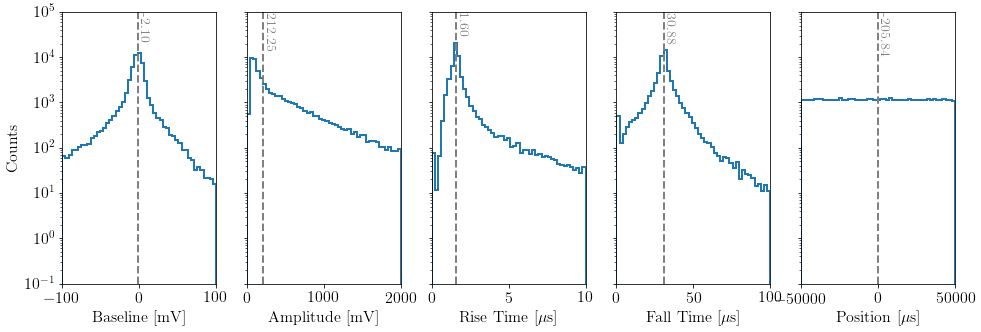

In [12]:
labels = ['Baseline [mV]', 'Amplitude [mV]', 'Rise Time [$\mu$s]', 'Fall Time [$\mu$s]', 'Position [$\mu$s]']
mins = [-100,0,0,0,start]
maxs = [100,2000,10,100,start+2*np.abs(start)]

fig, ax = plt.subplots(figsize=(16,5), ncols=5, nrows=1,sharey=True,facecolor='white')
ax[0].set_ylabel('Counts')
for i in range(np.shape(D0.fit_parameters)[1]):
    
    ax[i].hist(D0.fit_parameters[:,i], bins=np.linspace(mins[i],maxs[i],50), 
               color=colors[0], histtype='step', align='mid', label='All Events', lw=2)
    ax[i].vlines(np.median(D0.fit_parameters[:,i]), ymin=0.1, ymax=1e6, ls='--', color='grey')
    ax[i].text(s="{:.2f}".format(np.median(D0.fit_parameters[:,i])), 
               x=np.median(D0.fit_parameters[:,i])*1,y=10e4, color='grey', size=14, rotation=270, va='top')
    
    
    ax[i].set_xlabel(labels[i])
    ax[i].set_yscale('log')
    ax[i].set_xlim(mins[i], maxs[i])
    ax[i].set_ylim(1e-1, 10e4)
#     ax[i].legend(loc='upper right')
plt.savefig('fit_parameters.pdf')
plt.show()

In [13]:
# for popt in D0.fit_parameters:
#     val = D0.func()

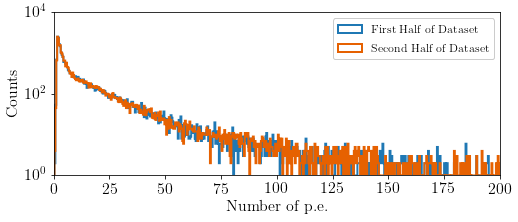

In [46]:
plt.figure(figsize=(8,3))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')

plt.xlim(0,200)
binmax = 400
binnum = 1000

plt.hist(np.array(D0.max[:int(len(D0.max)/2)])/(gain+1), bins=np.linspace(0,binmax,binnum), 
         histtype='step', lw=2, label="First Half of Dataset")
plt.hist(np.array(D0.max[int(len(D0.max)/2):])/(gain+1), bins=np.linspace(0,binmax,binnum), 
         histtype='step', lw=2, label="Second Half of Dataset")

plt.legend(loc='upper right')
plt.savefig('spectrum_loglog_calib.pdf')
plt.show()

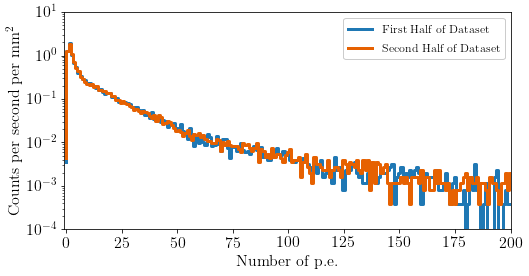

In [61]:
plt.figure(figsize=(8,4))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts per second per mm$^2$')
plt.yscale('log')

plt.xlim(-1,200)
binmax = 400
binnum = 400
binsize = binmax/binnum

duration = len(D0.Ch[1].Amp)*((D0.Ch[1].Time[-1]-D0.Ch[1].Time[0])/1e6)
area = 36.0


h,hx = np.histogram(np.array(D0.max[:int(len(D0.max)/2)])/(gain+1), bins=np.linspace(0,binmax,binnum))
h2,hx2 = np.histogram(np.array(D0.max[int(len(D0.max)/2):])/(gain+1), bins=np.linspace(0,binmax,binnum))

plt.step(hx[:-1], h/duration/area, lw=3, label="First Half of Dataset")
plt.step(hx2[:-1], h2/duration/area, lw=3, label="Second Half of Dataset")

# plt.hist(np.array(D0.max[:int(len(D0.max)/2)])/(gain+1), bins=np.linspace(0,binmax,binnum), 
#          histtype='step', lw=2, label="First Half of Dataset")
# plt.hist(np.array(D0.max[int(len(D0.max)/2):])/(gain+1), bins=np.linspace(0,binmax,binnum), 
#          histtype='step', lw=2, label="Second Half of Dataset")

plt.legend(loc='upper right')
plt.savefig('spectrum_loglog_calib.pdf')
plt.show()

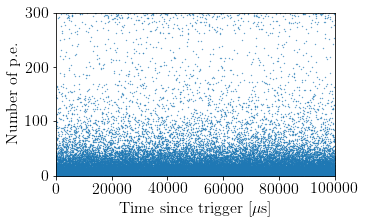

In [87]:
cut = np.where(D0.fit_parameters[:,4]!=0)

plt.figure(figsize=(5,3))
plt.ylim(0,300)
plt.xlabel('Time since trigger [$\mu$s]')
plt.ylabel('Number of p.e.')

plt.scatter(np.abs(D0.Ch[1].Time[0]-D0.fit_parameters[:,4][cut]), np.array(D0.max)/(gain+1), s=0.1 )
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
plt.xlabel('Amplitude [mV]')
plt.ylabel('Counts')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0,300)

binmax = 10000
binsize = 1
h,hx = np.histogram(D0.max-D0.fit_parameters[:,0][D0.fit_parameters[:,0]!=0], bins=np.arange(0,binmax,binsize))



# plt.hist(D0.fit_parameters[:,1], 
#          bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

# plt.hist(D0.max, bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

plt.step(hx[:-1], h, lw=3)

plt.savefig('spectrum_linlog.pdf')
plt.show()

[29.52035988526384, 55.51283038559165, 79.5734138707271, 105.58241768032543, 134.7797267825891]
[25.9924705  24.06058349 26.00900381 29.1973091 ]
26.314841724331316
26.000737154963076


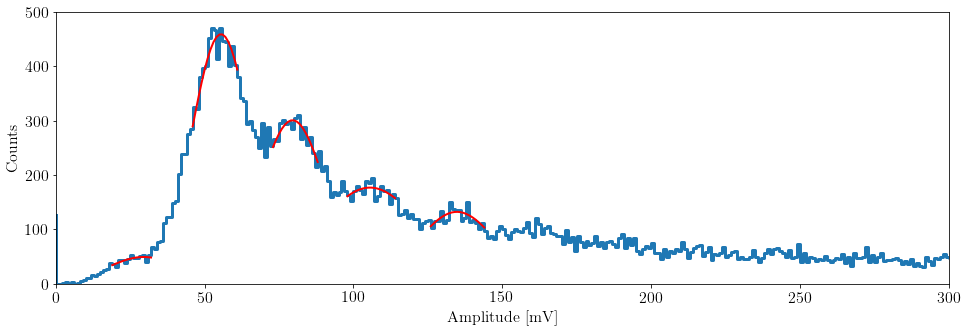

In [34]:
from scipy.optimize import curve_fit
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

binmax = 10000
binsize = 1
h,hx = np.histogram(D0.max-D0.fit_parameters[:,0][D0.fit_parameters[:,0]!=0], bins=np.arange(0,binmax,binsize))

cut0 = np.where((hx[:-1]>18) & (hx[:-1]<33))[0]
popt0, pcov0 = curve_fit(gauss, hx[:-1][cut0], h[cut0], p0=[500,50,10])

cut1 = np.where((hx[:-1]>45) & (hx[:-1]<62))[0]
popt1, pcov1 = curve_fit(gauss, hx[:-1][cut1], h[cut1], p0=[500,50,10])

cut2 = np.where((hx[:-1]>72) & (hx[:-1]<89))[0]
popt2, pcov2 = curve_fit(gauss, hx[:-1][cut2], h[cut2], p0=[300,70,10])

cut3 = np.where((hx[:-1]>97) & (hx[:-1]<115))[0]
popt3, pcov3 = curve_fit(gauss, hx[:-1][cut3], h[cut3], p0=[200,110,10])

cut4 = np.where((hx[:-1]>125) & (hx[:-1]<145))[0]
popt4, pcov4 = curve_fit(gauss, hx[:-1][cut4], h[cut4], p0=[100,140,10])

plt.figure(figsize=(16,5))
plt.xlabel('Amplitude [mV]')
plt.ylabel('Counts')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0,300)



# plt.hist(D0.fit_parameters[:,1], 
#          bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

# plt.hist(D0.max, bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

plt.step(hx[:-1], h, lw=3)
plt.plot(hx[:-1][cut0], gauss(hx[:-1][cut0], *popt0), color='r')
plt.plot(hx[:-1][cut1], gauss(hx[:-1][cut1], *popt1), color='r')
plt.plot(hx[:-1][cut2], gauss(hx[:-1][cut2], *popt2), color='r')
plt.plot(hx[:-1][cut3], gauss(hx[:-1][cut3], *popt3), color='r')
plt.plot(hx[:-1][cut4], gauss(hx[:-1][cut4], *popt4), color='r')

mus = [popt0[1], popt1[1], popt2[1], popt3[1], popt4[1]]
err = [popt0[1], popt1[1], popt2[1], popt3[1], popt4[1]]
print(mus)
print(np.diff(mus))
print(np.mean(np.diff(mus)))
print(np.median(np.diff(mus)))



plt.savefig('spectrum_linlin_fit.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0,300/(np.median(np.diff(mus))+1))

binmax = 10000
binsize = 1/(np.median(np.diff(mus))+1)

# plt.hist(D0.fit_parameters[:,1], 
#          bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

# plt.hist(D0.max, bins=np.arange(0,binmax,binsize), histtype='step', lw=3)

for x in range(12):
    plt.vlines(x=x, ymin=0, ymax=500, ls='--', color='grey', lw=1)
plt.step(hx[:-1]/(np.median(np.diff(mus))+1), h, lw=3)

plt.savefig('spectrum_linlog_calib.pdf')
plt.show()

In [99]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/', 
                    Selection='SiPM_31V_DCR_*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for File in D1.Files:
    D1.ImportDataFromHDF5(File, D1.Ch)

8


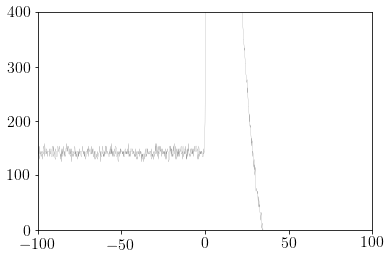

In [105]:
plt.figure()
plt.xlim(-100,100)
plt.ylim(0,400)

plt.plot(D1.Ch[1].Time, D1.Ch[1].Amp[0], color='k', lw=0.1)

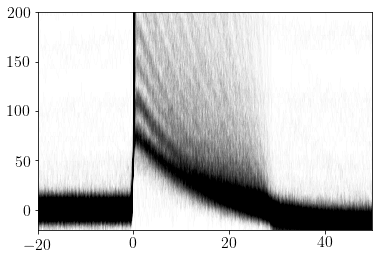

In [197]:
plt.figure()
plt.xlim(-20,50)
plt.ylim(-20,200)
for x in D1.Ch[1].Amp:
    plt.plot(D1.Ch[1].Time, x-np.mean(x[:100]), color='k', lw=0.01)

In [106]:
D1.max = []
for x in D1.Ch[1].Amp:
    D1.max.append(np.max(x-np.mean(x[:20])))
print(len(D1.max))

1328


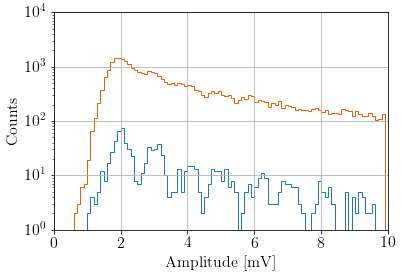

In [199]:
plt.figure()
# plt.xlim(0,400)
# plt.ylim(1e-1,1e2)
plt.yscale('log')
plt.xlabel('Amplitude [mV]')
plt.ylabel('Counts')
plt.grid()
# plt.hist(np.array(D1.max), bins=np.arange(0,200,5), histtype='step')

# plt.vlines(x=83, ymin=1, ymax=100)
# plt.vlines(x=118, ymin=1, ymax=100)
# plt.vlines(x=118+35, ymin=1, ymax=100)
# plt.vlines(x=118+2*35, ymin=1, ymax=100)




plt.hist((np.array(D1.max)-13)/35, bins=np.arange(0,10,0.1), histtype='step')
plt.hist(np.array(D0.max)/(gain+1), bins=np.arange(0,10,0.1), histtype='step')


plt.show()

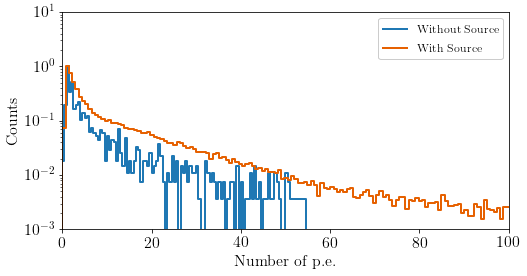

In [203]:
plt.figure(figsize=(8,4))
plt.xlim(0,100)
plt.ylim(1e-3,1e1)
plt.yscale('log')
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')

area = 36 
duration1 = len(D1.Ch[1].Amp)*((D1.Ch[1].Time[-1]-D1.Ch[1].Time[0])/1e6)
duration2 = len(D0.Ch[1].Amp)*((D0.Ch[1].Time[-1]-D0.Ch[1].Time[0])/1e6)

# print(dur)

hd, hdx = np.histogram(np.array(D1.max)-13, bins=np.arange(0,2300,20))
hs, hsx = np.histogram(np.array(D0.max), bins=np.arange(0,10000,20))

plt.step(hdx[:-1]/40, hd/np.max(hd), label='Without Source')
plt.step(hsx[:-1]/(gain+1), hs/np.max(hs), label='With Source')

plt.legend(loc='upper right')
plt.savefig('comparison_spectrum.pdf')
plt.show()

In [50]:
D2 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211109/', 
                    Selection='SiPM_33V_DCR_*.h5')
D2.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

# print(sorted(D2.Files)[:17])
# print(len(D2.Files))
for File in sorted(D2.Files)[:17]:
#     print(File)
    D2.ImportDataFromHDF5(File, D2.Ch)
Print=True

D2.max = []
D2.CleanAmp = []
for i,Amp in enumerate(D2.Ch[1].Amp):
    y = D2.get_filtered_waveform(D2.Ch[1].Time, Amp, lowfreq=10, highfreq=1000000, type='band', order=3)
    D2.max.append(np.max(y))
    D2.CleanAmp.append(y)

for ii, ch in enumerate(D2.Ch):
    ch.GetSampling()
    ch.Amp = np.array(ch.Amp)
    ch.Amp = ch.SubtractBaseline(Data=ch.Amp, state=Print)
    ch.GetAllMaxima(Data=ch.Amp, Time=5, state=Print)

 | Subtracting baseline...
 | Getting extrema of individual files...
 | Subtracting baseline...
 | Getting extrema of individual files...


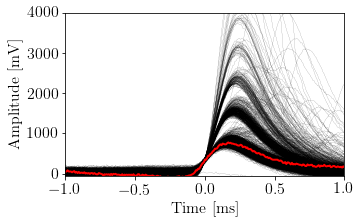

In [51]:
plt.figure(figsize=(5,3))
plt.xlim(-1,1)
plt.ylim(-50,4000)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [mV]')
for x in D2.Ch[1].Amp:
    plt.plot(D2.Ch[1].Time,x, color='k', lw=0.1)
plt.plot(D2.Ch[1].Time, D2.Ch[1].Amp[0], color='r', lw=2)
plt.savefig('scope_image.pdf')
plt.show()  

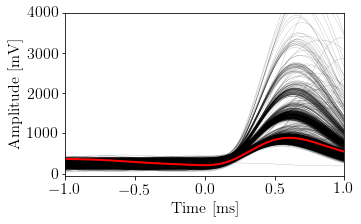

In [53]:
plt.figure(figsize=(5,3))
plt.xlim(-1,1)
plt.ylim(-50,4000)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [mV]')
for x in D2.CleanAmp:
    plt.plot(D2.Ch[1].Time,x, color='k', lw=0.1)
plt.plot(D2.Ch[1].Time, D2.CleanAmp[0], color='r', lw=2)
plt.savefig('scope_image.pdf')
plt.show()  

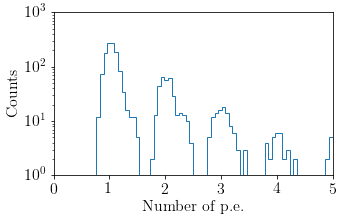

In [74]:
plt.figure(figsize=(5,3))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0,5)
# plt.grid()
# plt.hist(D2.Ch[1].Max, np.arange(0,4000,50), histtype='step')
gain = 780
plt.hist(D2.Ch[1].Max/gain, np.arange(0,4000/gain,50/gain), histtype='step')


# plt.hist(D2.max, np.arange(0,4000,20), histtype='step')

plt.savefig('pe_spectrum.pdf')
plt.show()

In [ ]:
# cc = 0
# for i,Amp in enumerate(D0.Ch[1].Amp):
#     print(i)
#     if i>10:
#         break
    
#     NewAmp = Amp-np.mean(Amp)
#     for j in range(count):
#         if len(D0.peak_pos[j]) > 0:
#             plt.figure()
#             plt.xlabel('Time [$\mu$s]')
#             plt.ylabel('Amplitude [mV]')

#             offset = window*j

#             cut = np.where((D0.Ch[1].Time > start+offset) & (D0.Ch[1].Time < start+offset+window))[0]
#             y = D0.get_filtered_waveform(D0.Ch[1].Time, NewAmp, lowfreq=10, highfreq=100000, type='band', order=3)[cut]

#             plt.plot(D0.Ch[1].Time[cut], NewAmp[cut], label='unfiltered', color='k')
#             plt.plot(D0.Ch[1].Time[cut], y, label='filtered')
            
#             for k,p in enumerate(D0.peak_pos[j]):
#                 plt.vlines(x=D0.Ch[1].Time[cut][p], ymin=-200,ymax=200, color='r', ls='--')
#                 try:
#                     plt.plot(D0.Ch[1].Time[cut][p-50:p+50], D0.func(D0.Ch[1].Time[cut][p-50:p+50], *D0.fit_parameters[cc]), 
#                          color='r', zorder=10)
#                 except:
#                     pass
#                 cc += 1
#             plt.xlim(D0.Ch[1].Time[cut][0], D0.Ch[1].Time[cut][-1])
#             plt.savefig('plots/{}_{}.pdf'.format(i,j))
#             plt.close()

In [ ]:
# cut = np.where((D0.Ch[1].Time > start+offset) & (D0.Ch[1].Time < start+offset+1000))[0]

# avg_time, avg_wvf = D0.get_averaged_waveform(D0.Ch[1].Time[cut], Amp[cut], avg=10)
# y = D0.get_filtered_waveform(D0.Ch[1].Time, Amp, lowfreq=10, highfreq=100000, type='band', order=3)[cut]
# print(len(avg_wvf), len(y), len(Amp[cut]))

In [ ]:
# print(D0.Ch[1].Time)

In [ ]:
# plt.figure(figsize=(8,5))

# plt.xlim(start+offset,start+offset+1000)
# plt.xlabel('Time [$\mu$s]')
# plt.ylabel('Amplitude [mV]')

# plt.plot(D0.Ch[1].Time[cut], Amp[cut], label='unfiltered', color='k')
# # plt.plot(avg_time, avg_wvf, label='averaged', color='g')
# plt.plot(D0.Ch[1].Time[cut], y, label='filtered')

# peaks,pdict = find_peaks(y, height=20, width=15, distance=50)
# popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], y, p0=[0, max_val, 1, 50, max_pos], maxfev=10000)

# for ii,p in enumerate(peaks): 
#     plt.vlines(x=D0.Ch[1].Time[cut][p], ymin=-200,ymax=200, color='r', ls='--')
#     peak_pos = D0.Ch[1].Time[cut][p]
#     peak_height = pdict['peak_heights'][ii]
#     fit_cut = np.where((D0.Ch[1].Time[cut]>D0.Ch[1].Time[cut][p]-20) 
#                        & (D0.Ch[1].Time[cut]<D0.Ch[1].Time[cut][p]+50))
#     popt, pcov = curve_fit(func, D0.Ch[1].Time[cut][fit_cut], y[fit_cut], 
#                            p0=[0,peak_height, 1, 40, peak_pos], 
#                            maxfev=10000)
#     plt.plot(D0.Ch[1].Time[cut][fit_cut], func(D0.Ch[1].Time[cut][fit_cut], *popt), color='r', zorder=10)

# plt.legend(loc='upper right')
# plt.ylim(-50,200)
# plt.show()

In [ ]:
# for ii,x in enumerate(Times):
#     if ii > 1000: 
#         break
#     plt.figure()
#     cut = np.where((D0.Ch[1].Time > x) & (D0.Ch[1].Time < x+1000))[0]
#     plt.plot(D0.Ch[1].Time[cut], Amp[cut])
    
#     max_val = np.max(Amp[cut])
#     max_pos_cut = np.where(Amp[cut] == np.max(Amp[cut]))[0][0]
#     max_pos = D0.Ch[1].Time[cut][max_pos_cut]
    
    
#     popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], Amp[cut], p0=[max_val, 10, 50, max_pos], maxfev=10000)
#     plt.plot(D0.Ch[1].Time[cut], func(D0.Ch[1].Time[cut], *popt), color='r')
#     print(max_val, max_pos, popt, np.max(func(D0.Ch[1].Time[cut], *popt)))
#     plt.show()
# # popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], Amp[cut], p0=[np.max(Amp[cut]), 1, 100, 4])
# # print(popt)

# # plt.plot(D0.Ch[1].Time[cut], func(D0.Ch[1].Time[cut], *popt), color='r')
# # print(np.max(func(D0.Ch[1].Time[cut], *popt)))
